### do gen-matching with delphes root files

In [73]:
#env : Lpr

In [74]:
import uproot
import awkward as ak

from glob import glob
from coffea.nanoevents import NanoEventsFactory, DelphesSchema, BaseSchema

# from coffea import nanoevents
# from coffea.nanoevents.methods.base import NanoEventsArray
# from coffea.analysis_tools import Weights, PackedSelection
# from coffea.nanoevents.methods import nanoaod
# from coffea.nanoevents.methods import vector
# from coffea.lookup_tools.dense_lookup import dense_lookup
# from coffea.nanoevents.methods.nanoaod import MuonArray, JetArray, FatJetArray, GenParticleArray
# ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict, Tuple
from copy import copy

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

from tqdm import tqdm

# import fastjet

import pathlib

# import jetnet

import os

import boost_histogram as bh

In [75]:
plot_dir = "../plots/tagger/18Aug2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [76]:
import custom
print("Loaded CustomDelphesSchema:", custom.CustomDelphesSchema)


Loaded CustomDelphesSchema: <class 'custom.CustomDelphesSchema'>


In [77]:
delphes_roots = {
    'TTbar_semilep' : "/data/bond/zhaoyz/Pheno/ntuplizer/output/sm/TTbar_semilep_set1_12M/ntuple_events_delphes_27.root",
}
# delphes_roots = {
#     'TTbar_semilep' : "/data/bond/zhaoyz/Pheno/ttbar_Wcb/TTbar_semilep/delphes_9.root",
# }     
files = {typefile : {} for typefile in delphes_roots}
for typefile in delphes_roots:
    # files[typefile] = uproot.lazy(delphes_roots[typefile])
    files[typefile] = NanoEventsFactory.from_root(
        delphes_roots[typefile],
        treepath="/tree",
        schemaclass=custom.CustomDelphesSchema,
    ).events()

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch JetPUPPI_size in <TTree 'tree' (3386 branches) at 0x7f67e59535b0>, taking first instance
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch Particle_size in <TTree 'tree' (3386 branches) at 0x7f67e59535b0>, taking first instance
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch JetPUPPIAK8_size in <TTree 'tree' (3386 branches) at 0x7f67e59535b0>, taking first instance
  warnings.warn(


jet_branchs:{'jet_probs_76', 'jet_hidneurons_104', 'jet_probs_60', 'jet_probs_18', 'jet_hidneurons_36', 'jet_probs_75', 'jet_hidneurons_84', 'jet_probs_171', 'jet_hidneurons_26', 'jet_probs_185', 'jet_probs_33', 'jet_probs_10', 'jet_hidneurons_37', 'jet_hidneurons_73', 'jet_hidneurons_40', 'jet_hidneurons_95', 'jet_probs_86', 'jet_hidneurons_42', 'jet_hidneurons_57', 'jet_hidneurons_88', 'jet_probs_66', 'jet_hidneurons_13', 'jet_hidneurons_89', 'jet_probs_186', 'jet_hidneurons_85', 'jet_hidneurons_121', 'jet_probs_81', 'jet_hidneurons_33', 'jet_hidneurons_96', 'jet_probs_26', 'jet_hidneurons_125', 'jet_hidneurons_20', 'jet_probs_158', 'jet_probs_94', 'jet_probs_92', 'jet_hidneurons_117', 'jet_hidneurons_108', 'jet_hidneurons_110', 'jet_probs_164', 'jet_hidneurons_91', 'jet_probs_42', 'jet_probs_107', 'jet_probs_137', 'jet_hidneurons_47', 'jet_hidneurons_70', 'jet_probs_27', 'jet_probs_71', 'jet_hidneurons_32', 'jet_hidneurons_25', 'jet_probs_108', 'jet_probs_151', 'jet_probs_149', 'jet

In [78]:
### find the score label index
labels = [
    #  H->2 prong
    "H_bb", "H_cc", "H_ss", "H_qq", "H_bc", "H_cs", "H_bq", "H_cq", "H_sq", "H_gg", "H_ee", "H_mm", "H_tauhtaue", "H_tauhtaum", "H_tauhtauh", 

    #  H->4/3 prong
    "H_AA_bbbb", "H_AA_bbcc", "H_AA_bbss", "H_AA_bbqq", "H_AA_bbgg", "H_AA_bbee", "H_AA_bbmm",
    "H_AA_bbtauhtaue", "H_AA_bbtauhtaum", "H_AA_bbtauhtauh",

    "H_AA_bbb", "H_AA_bbc", "H_AA_bbs", "H_AA_bbq", "H_AA_bbg", "H_AA_bbe", "H_AA_bbm",

    "H_AA_cccc", "H_AA_ccss", "H_AA_ccqq", "H_AA_ccgg", "H_AA_ccee", "H_AA_ccmm",
    "H_AA_cctauhtaue", "H_AA_cctauhtaum", "H_AA_cctauhtauh",

    "H_AA_ccb", "H_AA_ccc", "H_AA_ccs", "H_AA_ccq", "H_AA_ccg", "H_AA_cce", "H_AA_ccm",

    "H_AA_ssss", "H_AA_ssqq", "H_AA_ssgg", "H_AA_ssee", "H_AA_ssmm",
    "H_AA_sstauhtaue", "H_AA_sstauhtaum", "H_AA_sstauhtauh",

    "H_AA_ssb", "H_AA_ssc", "H_AA_sss", "H_AA_ssq", "H_AA_ssg", "H_AA_sse", "H_AA_ssm",

    "H_AA_qqqq", "H_AA_qqgg", "H_AA_qqee", "H_AA_qqmm",
    "H_AA_qqtauhtaue", "H_AA_qqtauhtaum", "H_AA_qqtauhtauh",

    "H_AA_qqb", "H_AA_qqc", "H_AA_qqs", "H_AA_qqq", "H_AA_qqg", "H_AA_qqe", "H_AA_qqm",

    "H_AA_gggg", "H_AA_ggee", "H_AA_ggmm",
    "H_AA_ggtauhtaue", "H_AA_ggtauhtaum", "H_AA_ggtauhtauh",

    "H_AA_ggb", "H_AA_ggc", "H_AA_ggs", "H_AA_ggq", "H_AA_ggg", "H_AA_gge", "H_AA_ggm",

    "H_AA_bee", "H_AA_cee", "H_AA_see", "H_AA_qee", "H_AA_gee",
    "H_AA_bmm", "H_AA_cmm", "H_AA_smm", "H_AA_qmm", "H_AA_gmm",

    "H_AA_btauhtaue", "H_AA_ctauhtaue", "H_AA_stauhtaue", "H_AA_qtauhtaue", "H_AA_gtauhtaue",
    "H_AA_btauhtaum", "H_AA_ctauhtaum", "H_AA_stauhtaum", "H_AA_qtauhtaum", "H_AA_gtauhtaum",
    "H_AA_btauhtauh", "H_AA_ctauhtauh", "H_AA_stauhtauh", "H_AA_qtauhtauh", "H_AA_gtauhtauh",

    #  (H+H-: H_AA_bbcs, H_AA_bbsq, H_AA_ssbc, H_AA_ssbq not available)
    "H_AA_qqqb", "H_AA_qqqc", "H_AA_qqqs",
    "H_AA_bbcq",
    "H_AA_ccbs", "H_AA_ccbq", "H_AA_ccsq",
    "H_AA_sscq",
    "H_AA_qqbc", "H_AA_qqbs", "H_AA_qqcs",
    "H_AA_bcsq",

    "H_AA_bcs", "H_AA_bcq", "H_AA_bsq", "H_AA_csq", 

    "H_AA_bcev", "H_AA_csev", "H_AA_bqev", "H_AA_cqev", "H_AA_sqev", "H_AA_qqev",
    "H_AA_bcmv", "H_AA_csmv", "H_AA_bqmv", "H_AA_cqmv", "H_AA_sqmv", "H_AA_qqmv",
    "H_AA_bctauev", "H_AA_cstauev", "H_AA_bqtauev", "H_AA_cqtauev", "H_AA_sqtauev", "H_AA_qqtauev",
    "H_AA_bctaumv", "H_AA_cstaumv", "H_AA_bqtaumv", "H_AA_cqtaumv", "H_AA_sqtaumv", "H_AA_qqtaumv",
    "H_AA_bctauhv", "H_AA_cstauhv", "H_AA_bqtauhv", "H_AA_cqtauhv", "H_AA_sqtauhv", "H_AA_qqtauhv",


    "QCD_bbccss", "QCD_bbccs", "QCD_bbcc", "QCD_bbcss", "QCD_bbcs", "QCD_bbc", "QCD_bbss", "QCD_bbs", "QCD_bb",
    "QCD_bccss", "QCD_bccs", "QCD_bcc", "QCD_bcss", "QCD_bcs", "QCD_bc", "QCD_bss", "QCD_bs", "QCD_b",
    "QCD_ccss", "QCD_ccs", "QCD_cc", "QCD_css", "QCD_cs", "QCD_c", "QCD_ss", "QCD_s", "QCD_light",

]

index_hbc = labels.index("H_bc")
index_hbb = labels.index("H_bb")
index_hcc = labels.index("H_cc")
index_qcd_start = labels.index("QCD_bbccss")

In [79]:
files[typefile].fields

['jet_probs_76',
 'jet_hidneurons_104',
 'jet_probs_60',
 'jet_probs_18',
 'jet_hidneurons_36',
 'jet_probs_75',
 'jet_hidneurons_84',
 'jet_probs_171',
 'jet_hidneurons_26',
 'jet_probs_185',
 'jet_probs_33',
 'jet_probs_10',
 'jet_hidneurons_37',
 'jet_hidneurons_73',
 'jet_hidneurons_40',
 'jet_hidneurons_95',
 'jet_probs_86',
 'jet_hidneurons_42',
 'jet_hidneurons_57',
 'jet_hidneurons_88',
 'jet_probs_66',
 'jet_hidneurons_13',
 'jet_hidneurons_89',
 'jet_probs_186',
 'jet_hidneurons_85',
 'jet_hidneurons_121',
 'jet_probs_81',
 'jet_hidneurons_33',
 'jet_hidneurons_96',
 'jet_probs_26',
 'jet_hidneurons_125',
 'jet_hidneurons_20',
 'jet_probs_158',
 'jet_probs_94',
 'jet_probs_92',
 'jet_hidneurons_117',
 'jet_hidneurons_108',
 'jet_hidneurons_110',
 'jet_probs_164',
 'jet_hidneurons_91',
 'jet_probs_42',
 'jet_probs_107',
 'jet_probs_137',
 'jet_hidneurons_47',
 'jet_hidneurons_70',
 'jet_probs_27',
 'jet_probs_71',
 'jet_hidneurons_32',
 'jet_hidneurons_25',
 'jet_probs_108',
 

In [80]:
# use leading pT jet first, anyway we will only select one AK8 jet in the end
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret

import math
def delta_r(a, b):
    deta = a.Eta - b.Eta
    dphi = (a.Phi - b.Phi + math.pi) % (2 * math.pi) - math.pi
    return np.hypot(deta, dphi)

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.ROOT)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

### Investigate jet information

In [81]:
events = files["TTbar_semilep"]


#### let's see the #AK8 jets distribution

In [82]:
# initially we only test leading JetPUPPIAK8 jet(as candidate fatjet) matching situations
# anyway, we will use one AK8 jets in the end
# now, we use the 
# num_jets = 1
# candidate_fatjets = ak.flatten(ak.pad_none(events.JetPUPPIAK8, num_jets, axis=1)[:, :num_jets], axis = 1)

In [83]:
def get_hbcvsqcd(df):
    df["hbc"] = df[f"jet_probs_{str(index_hbc)}"]
    df["qcd"] = ak.zeros_like(df["hbc"])
    for idx in range(index_qcd_start,188):
        df["qcd"] = df["qcd"] + df[f"jet_probs_{str(idx)}"]
    df["hbcvsqcd"] = df["hbc"]/(df["hbc"] + df["qcd"])



In [117]:
#compute tagger score
leading_tagger = np.max(events[f"jet_probs_{str(index_hbc)}"],axis = 1) #leading tagger score
leading_tagger_indices = (events[f"jet_probs_{str(index_hbc)}"] == leading_tagger)

#order other object
leading_hbc = events[f"jet_probs_{str(index_hbc)}"][leading_tagger_indices][:,0]
get_hbcvsqcd(events)
leading_hbcvsqcd = events["hbcvsqcd"][leading_tagger_indices][:,0]
#currently top not available

#candidate jet is the jet with leading Hbc tagger
leading_fatjet = events.JetPUPPIAK8[leading_tagger_indices][:,0]
candidate_fatjets = leading_fatjet

In [85]:
# how to compute soft-drop mass
candidate_fatjets.SoftDroppedP4_5[...,0].mass

<Array [88.2, 74.1, 46, ... 71.9, 83.9, 68.8] type='1022 * ?float64'>

/tmp/ipykernel_2611376/3272209719.py:50: RuntimeWarning: invalid value encountered in true_divide
  number = h**2 / var
/tmp/ipykernel_2611376/3272209719.py:67: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= var/h
/tmp/ipykernel_2611376/3272209719.py:68: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= var/h
/tmp/ipykernel_2611376/3272209719.py:50: RuntimeWarning: invalid value encountered in true_divide
  number = h**2 / var
/tmp/ipykernel_2611376/3272209719.py:67: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= var/h
/tmp/ipykernel_2611376/3272209719.py:68: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= var/h


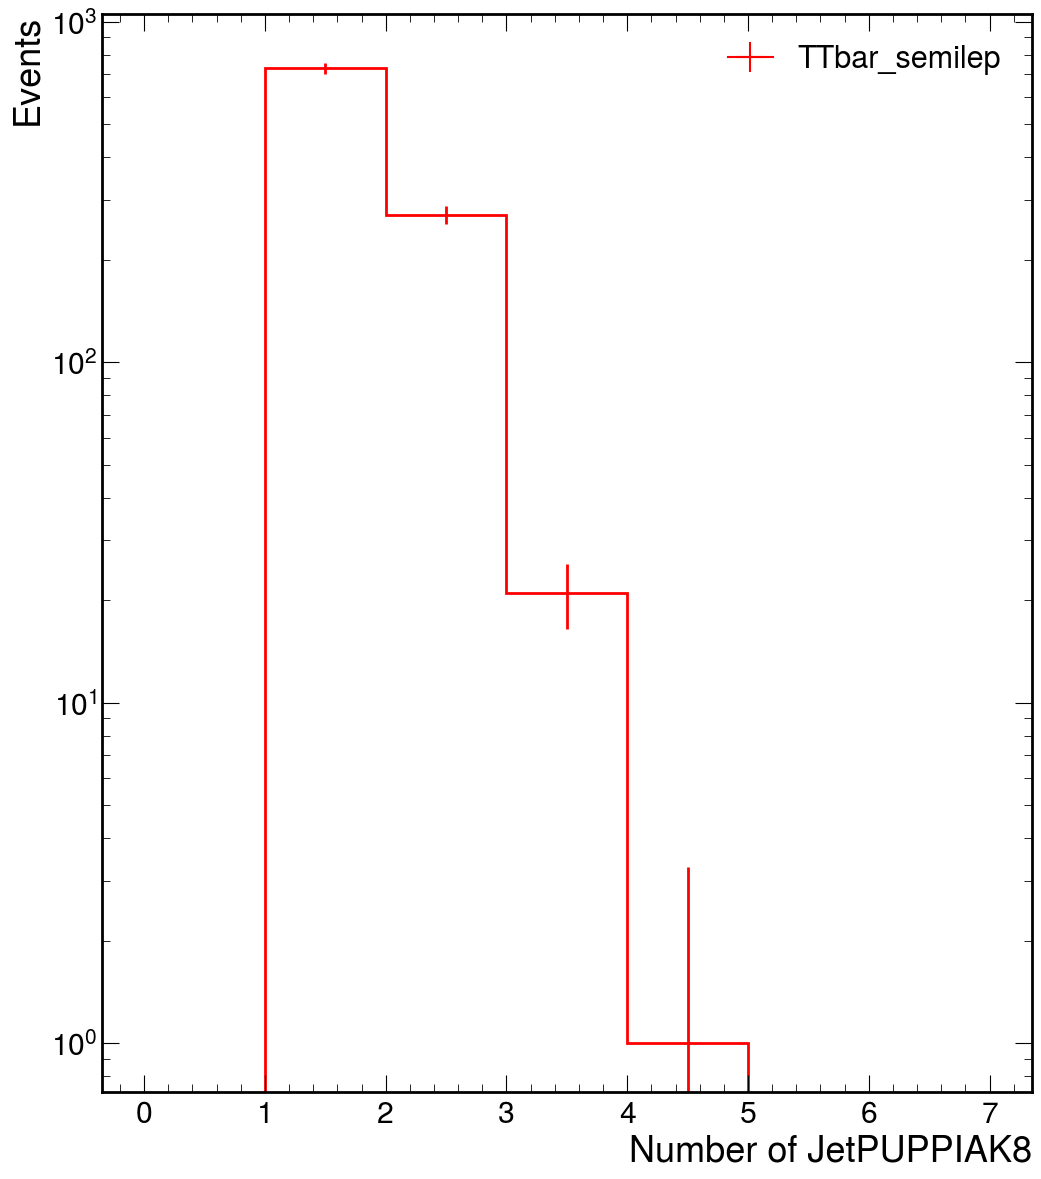

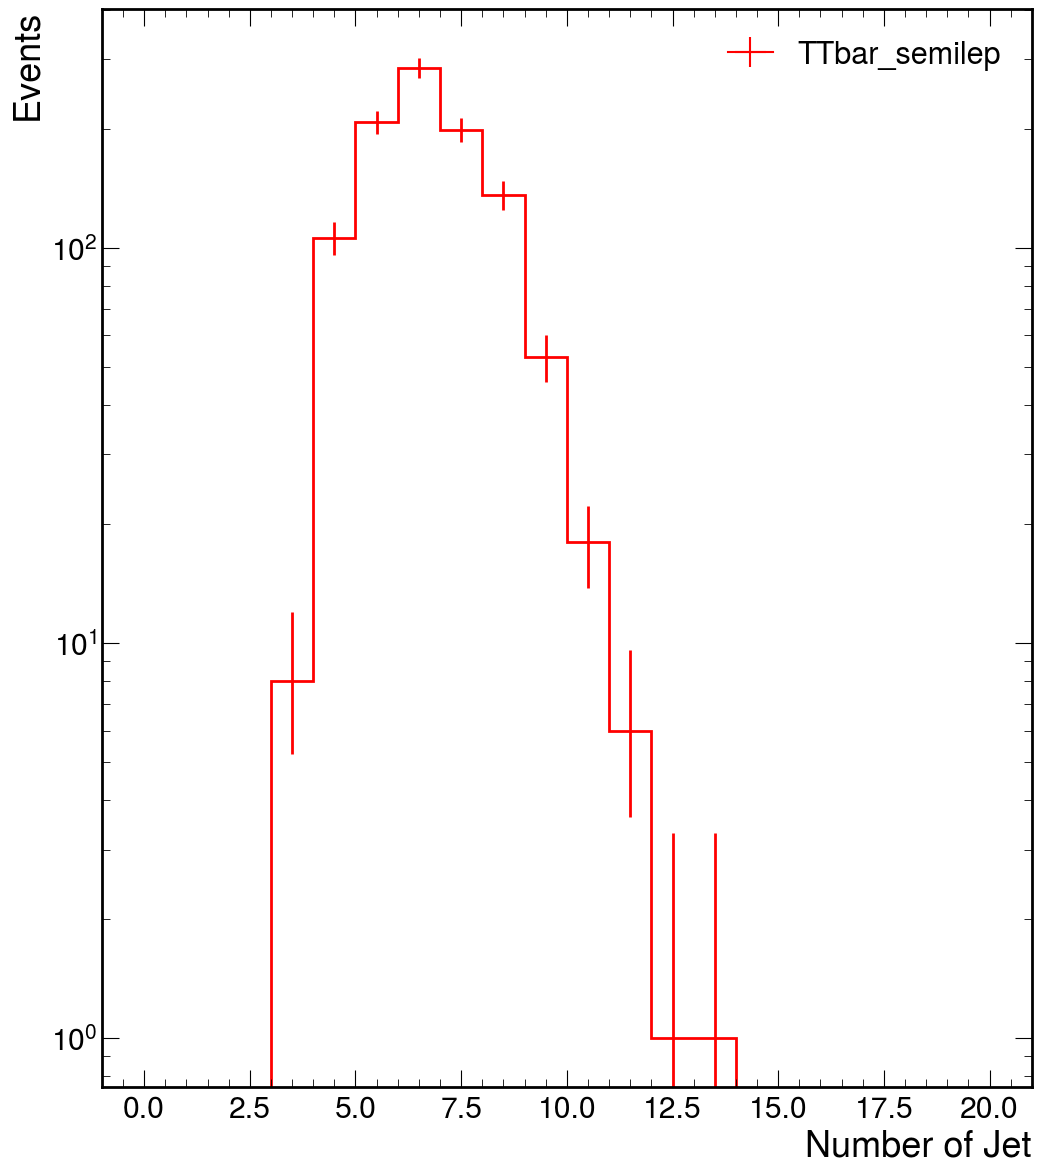

In [86]:
def plot_NAK8(jets, n_min, n_max, nbins, sample , jet_type):
    f = plt.figure(figsize=(12,14))
    ax = f.add_subplot(1, 1, 1)
    hist_region = bh.Histogram(bh.axis.Regular(nbins, n_min, n_max), storage=bh.storage.Weight())
    hist_region.fill(ak.num(jets.Eta, axis = 1))
    hist_value_up = flow(hist_region)[0]
    hist_var_up   = flow(hist_region)[1]
    err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
    hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label=sample, histtype='step', stack=False, linewidth=2, ax=ax, color = "red")
    ax.set_xlabel(f"Number of {jet_type}")
    ax.set_ylabel("Events")
    ax.set_yscale('log') 
    ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.05,0.83,region + "," + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
    plt.savefig(f"{plot_dir}/NAK8_{jet_type}.pdf", bbox_inches='tight')    

plot_NAK8(events.JetPUPPIAK8,0,7,7,"TTbar_semilep", "JetPUPPIAK8")
plot_NAK8(events.JetPUPPI,0,20,20,"TTbar_semilep","Jet")

### jet matching

In [87]:
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
b_PDGID = 5
c_PDGID = 4
TOP_PDGID = 6

g_PDGID = 21

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
H_PDGID = 25

#define deltaR
deltaR = 0.8

In [88]:
# finding the two gen tops

tops = events.Particle[
    (abs(events.Particle.PID) == TOP_PDGID) * (events.Particle.Status == 62)
]

In [89]:
tops.PID

<Array [[-6, 6], [6, -6], ... [-6, 6], [6, -6]] type='1022 * var * int32[paramet...'>

In [90]:
# collect all bs
bs = events.Particle[tops.D2]

In [91]:
# find the last W index

def find_last_position(arr, value):
    mask = (arr == value)
    reversed_mask = mask[:, ::-1]
    reversed_positions = ak.argmax(reversed_mask, axis=1)
    lengths = ak.num(arr, axis=1)
    positions = lengths - 1 - reversed_positions
    return positions



In [92]:
pos_w_plus = find_last_position(events.Particle.PID, 24)
pos_w_plus

<Array [626, 741, 589, 211, ... 721, 636, 512] type='1022 * ?int64'>

In [93]:
pos_w_minus = find_last_position(events.Particle.PID, -24)
pos_w_minus

<Array [612, 743, 579, 218, ... 725, 631, 519] type='1022 * ?int64'>

In [94]:
#last copy W position
w_index_array = ak.Array(ak.Array([pos_w_plus, pos_w_minus]).to_numpy().T)

In [95]:
# collect last copy W
ws = events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, w_index_array.to_numpy()]

In [96]:
# define hadronic decay W
had_w_sel = (abs(events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, ws.D1.to_numpy()].PID) <= 5)

In [97]:
# collect all hadronic decay W in all events
had_ws = ws[had_w_sel]

In [98]:
# collect hadronic W's daughter
had_ws_D1 = ak.flatten(events.Particle[ak.singletons(had_ws.D1)], axis = 1)
had_ws_D2 = ak.flatten(events.Particle[ak.singletons(had_ws.D2)], axis = 1)

In [99]:
had_ws_D1_match = (delta_r(had_ws_D1,candidate_fatjets) < deltaR)
had_ws_D2_match = (delta_r(had_ws_D2,candidate_fatjets) < deltaR)

In [100]:
# W decay tag
wcd = (( abs(had_ws_D1.PID) == 1) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 1 ))
wcs = (( abs(had_ws_D1.PID) == 3) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 3 ))
wcb = (( abs(had_ws_D1.PID) == 5) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 5 ))

wud = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 1 )) | (( abs(had_ws_D1.PID) == 1) & (abs(had_ws_D2.PID) == 2 ))
wub = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 5 )) | (( abs(had_ws_D1.PID) == 5) & (abs(had_ws_D2.PID) == 2 ))
wus = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 3 )) | (( abs(had_ws_D1.PID) == 3) & (abs(had_ws_D2.PID) == 2 ))

In [101]:
ak.sum(wcd) + ak.sum(wcs) + ak.sum(wcb) + ak.sum(wud) + ak.sum(wub) + ak.sum(wus)

1022

In [102]:
ak.sum(wcb)

2

In [103]:
ak.sum(wcd)

28

In [104]:
# collect hadronic decay tops' b(the same sign with hadronic W)
bs_had = ak.flatten(ak.pad_none(bs[had_ws.Charge == abs(bs.PID)/bs.PID ], 1, axis = 1, clip = True), axis = 1)

In [105]:
had_b_jet_match = (delta_r(bs_had,candidate_fatjets) < deltaR)

In [106]:
match_dict = {
    "top_matched(t->bqq)": had_ws_D1_match * had_ws_D2_match * had_b_jet_match,
    "top_matched(t->bq)": (had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match) | (~had_ws_D1_match * had_ws_D2_match * had_b_jet_match),
    "W_matched(W->cd)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcd,
    "W_matched(W->cs)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcs,
    "W_matched(W->cb)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcb,
    "W_matched(W->ud)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wud,
    "W_matched(W->ub)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wub,
    "W_matched(W->us)": ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wus,
    "b_matched(had.t)" : ~had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match,
    "q_matched(had.W)" : ( ~had_ws_D1_match * had_ws_D2_match * ~had_b_jet_match) | (had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match),
    "unmatched" : ~had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match,
}

In [107]:
len(events)

1022

In [108]:
len_n = 0
for match in match_dict:
    len_n += np.sum(np.sum(match_dict[match]))
print(len_n)

1022


In [109]:
np.sum(match_dict["top_matched(t->bqq)"])

38

In [110]:
np.sum(match_dict["top_matched(t->bq)"])

235

In [111]:
np.sum(match_dict["W_matched(W->cb)"])

1

In [112]:
np.sum(match_dict["unmatched"])

378

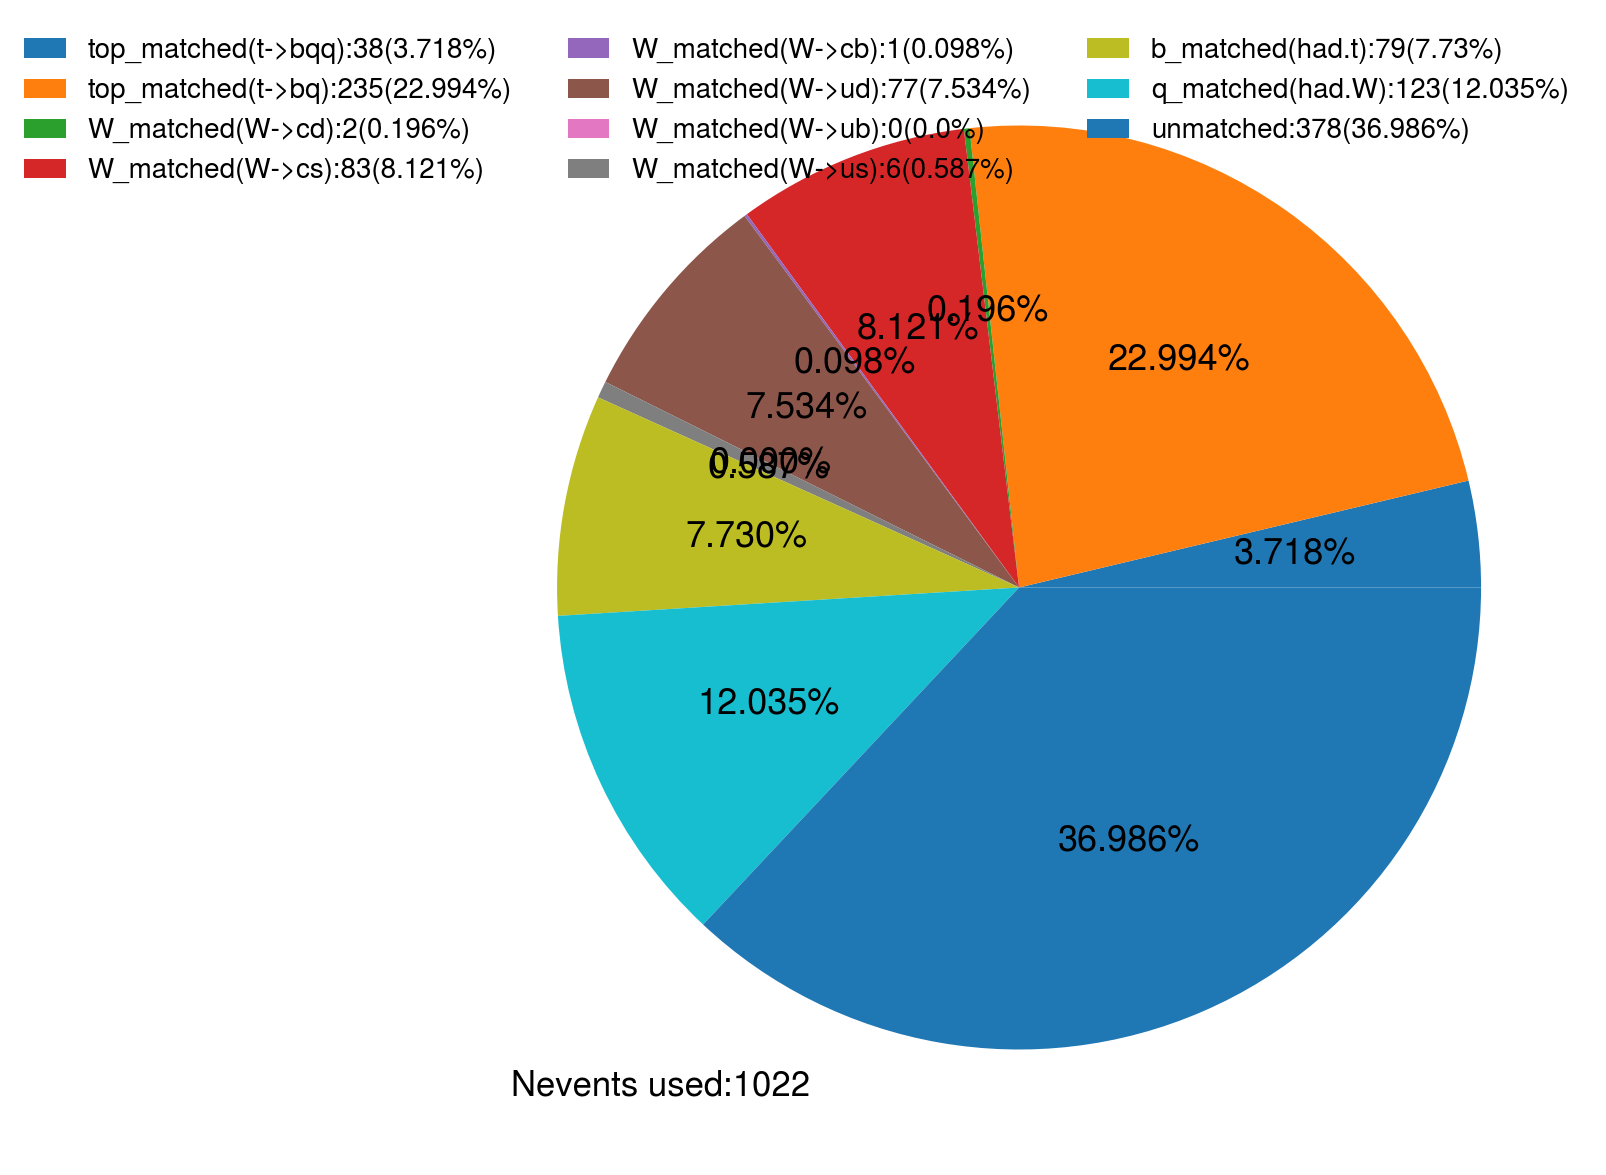

In [113]:
# make a pie-chart to visulize the fraction
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

plt.figure(figsize=(15,15))
ax=plt.gca()
plt.grid()
labels = ['top_matched(t->bqq)', 'top_matched(t->bq)', 'W_matched(W->cd)','W_matched(W->cs)','W_matched(W->cb)','W_matched(W->ud)', 'W_matched(W->ub)', 'W_matched(W->us)', "b_matched(had.t)", "q_matched(had.W)",'unmatched']
sizes = []
len_n = len(match_dict["unmatched"])
labels_with_num = []
for label in labels:
    sizes.append(np.sum(match_dict[label]))
    labels_with_num.append(label + ":"  + str(np.sum(match_dict[label])) + "(" + str(round(np.sum(match_dict[label])*100/len_n,3)) + "%)")
# colors = ['#ffff00', '#2ca02c', '#ff7f0e', '#800080','red']
# highlight some component(optional)
explode = (0., 0, 0, 0, 0, 0,0,0,0,0, 0)
# plot the pie chat
plt.pie(sizes, labels=None, autopct='%1.3f%%', startangle=0, explode=explode, radius=1)
plt.legend(labels_with_num, loc='upper right',fontsize = 20, ncol =3)
# set title
# plt.title(r'$\ \ Signal' + "" + r'\ jet_{a}\ decomposition $',fontsize = 30)
# plt.title("ttbar(semi-lep) samples Wcb candidate jet decomposition", fontsize = 25)
# title_text = 'Pie Chart Example'

plt.text(-1.1,-1.1, f"Nevents used:{str(len_n)}", fontsize=25)
plt.savefig(f"{plot_dir}/Piechart_"+ "wcb" + "_deco.pdf", bbox_inches='tight')
plt.show()

### add output: necessary information for making plot

In [116]:
input_file = delphes_roots["TTbar_semilep"]
output_file = "/data/bond/zhaoyz/Pheno/slimmedtree/slim_" + delphes_roots["TTbar_semilep"].split("/")[-1] 
with uproot.recreate(output_file) as root_file:
    root_file["PKUTree"] = {
        "PT_j": np.array(candidate_fatjets.PT),
        "Eta_j": np.array(candidate_fatjets.Eta),
        "Phi_j": np.array(candidate_fatjets.Phi),
        "Mass_j": np.array(candidate_fatjets.Mass),
        "Mass_j_sd": np.array(candidate_fatjets.SoftDroppedP4_5[...,0].mass),
        "top_matched_bqq" : ak.Array(np.array(match_dict["top_matched(t->bqq)"]).astype(int)),
        "top_matched_bq" : ak.Array(np.array(match_dict["top_matched(t->bq)"]).astype(int)),
        "w_matched_cd" : ak.Array(np.array(match_dict["W_matched(W->cd)"]).astype(int)),
        "w_matched_cs" : ak.Array(np.array(match_dict["W_matched(W->cs)"]).astype(int)),
        "w_matched_cb" : ak.Array(np.array(match_dict["W_matched(W->cb)"]).astype(int)),
        "w_matched_ud" : ak.Array(np.array(match_dict["W_matched(W->ud)"]).astype(int)),
        "w_matched_ub" : ak.Array(np.array(match_dict["W_matched(W->ub)"]).astype(int)),
        "w_matched_us" : ak.Array(np.array(match_dict["W_matched(W->us)"]).astype(int)),
        "b_matched" : ak.Array(np.array(match_dict["b_matched(had.t)"]).astype(int)),
        "q_matched" : ak.Array(np.array(match_dict["q_matched(had.W)"]).astype(int)),        
        "unmatched" : ak.Array(np.array(match_dict["unmatched"]).astype(int)),
        "isWcb" : ak.Array(np.array(wcb).astype(int)),
        "NAK8" : ak.num(events.JetPUPPIAK8.Eta, axis = 1),
        "NAK4" : ak.num(events.JetPUPPI.Eta, axis = 1),
        "hbcvsqcd" : np.array(leading_hbcvsqcd),
        "hbc" : np.array(leading_hbc),
    }